In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simpleGenerator import Croupier

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика

In [2]:
casino = Croupier()
for i in range(10):
    print(casino())

(2, 'F')
(1, 'U')
(2, 'U')
(6, 'U')
(2, 'U')
(6, 'U')
(6, 'U')
(1, 'U')
(2, 'U')
(1, 'U')


Сгенерируем датасеты размером 1 000, 10 000 и 100 000

In [3]:
dataset300 = []
dataset300Labels = []

casino = Croupier()

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

In [15]:
dataset1000 = []
dataset1000Labels = []

casino = Croupier()

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

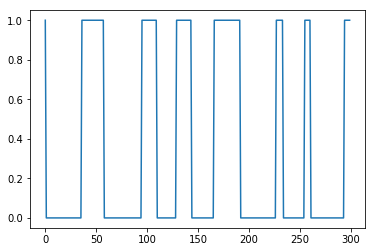

In [16]:
lab300 = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab)

Определим базовый класс алгоритма

In [5]:
class baseAlgo():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

In [30]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability*np.max( self.v[index-1] * self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] * self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability*self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.86
Probability: 2.5616090878881863e-235


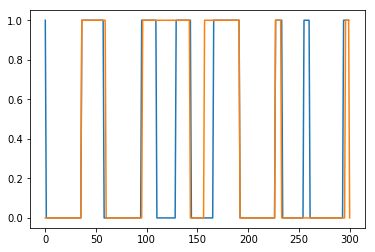

In [35]:
hackCasinoViterbi = algorithmViterbi(dataset300)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.687
Probability: 0.0


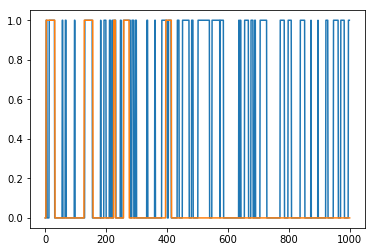

In [36]:
hackCasinoViterbi = algorithmViterbi(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

In [65]:
class baseAlgoLog():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.log([0.95,0.05]), # to F, to U
            'U': np.log([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': np.log(2/3),
            'U': np.log(1/3)
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': np.log([1/6 for i in range(6)]),
            'U': np.log([.1,.1,.1,.1,.1,.5])
        }

In [66]:
class algorithmViterbiLog(baseAlgoLog):
    def __init__(self, data):
        baseAlgoLog.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability + np.max( self.v[index-1] + self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] + self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability + self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = np.e**max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.86
Probability: 2.5616090878884953e-235


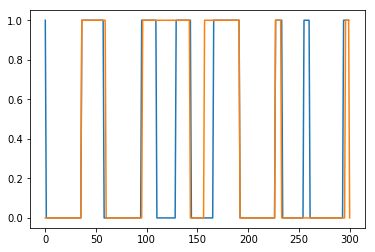

In [67]:
hackCasinoViterbiLog = algorithmViterbiLog(dataset300)
result = hackCasinoViterbiLog()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.748
Probability: 2.5616090878884953e-235


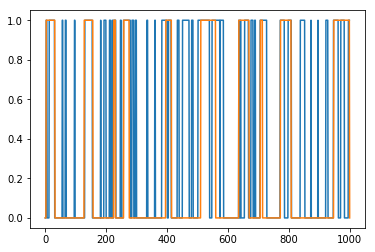

In [69]:
hackCasinoViterbi = algorithmViterbiLog(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

In [70]:
class baseAlgo():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

In [93]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.f = []
        self.pathProbability = None
    
    def step(self, index):
        self.f.append([])
        for state in self.states:
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            previuosState = self.f[index-1]
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([self.startProbability[state] for state in self.states]) # Не уверен
        # Recursion
        for i in range(1,self.L):
            self.step(i)
        self.pathProbability = sum(self.f[-1])

In [94]:
forwardHack = forwardAlgorithm(dataset300)
forwardHack()

1.3542476897034294e-222

In [146]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.b = []
        self.pathProbability = None
    
    def step(self, index):
        self.b.append([])
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            nextState = self.b[-2]
            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        
        self.b.append([1 for state in self.states])
        #Recursion
        for i in range(self.L-1,1,-1): # С двойки?
            self.step(i)
            
        # Finish # перевернуть b
        self.b = self.b[::-1]
        self.pathProbability = sum([
            self.transitionsProbability[state]*self.diceValueProbability[state][self.data[0] - 1] 
            for state in self.states] * np.array(self.b[0]))
        self.pathProbability = sum(self.pathProbability)

In [147]:
backwardHack = backwardAlgorithm(dataset300)
backwardHack()

4.225111988619696e-222

In [ ]:
class PosteriorDecoding(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
    def step(self, init):
        pass
    
    def __call__(self):
        pass
    
    def initialization(self):
        pass

In [ ]:
class BaumWelchTrainig():
    def __init__(self):
        pass